In [138]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 

## Load data

In [139]:
spark_df = pd.read_csv('./spark_cleaned_data_more_features.csv')

id_cols = ['subject_sp_id', 'respondent_sp_id', 'family_id', 'biomother_id','biofather_id']
# age_cols = ['age_at_eval_months', 'age_at_eval_years', 'age_at_registration_months']
race_cols = ['race_asian','race_african_amer', 'race_native_amer', 'race_native_hawaiian',
       'race_white', 'race_other', 'hispanic']

spark_df = spark_df.drop(id_cols, axis=1)
# spark_df  = spark_df.drop(age_cols, axis=1)
spark_df  = spark_df.drop(race_cols, axis=1)


print(spark_df.shape)
spark_df.columns

(131811, 28)


Index(['mood_hoard', 'dev_motor', 'mood_sep_anx', 'mood_soc_anx',
       'birth_oth_calc', 'behav_intermitt_explos', 'behav_adhd', 'dev_lang',
       'attn_behav', 'dev_soc_prag', 'dev_ld', 'mood_dmd', 'psych_oth_calc',
       'dev_speech', 'mood_anx', 'mood_or_anx', 'asd', 'neuro_oth_calc', 'sex',
       'dev_mutism', 'mood_ocd', 'mood_bipol', 'behav_odd', 'dev_lang_dis',
       'gen_dx_oth_calc_self_report', 'mood_dep', 'behav_conduct',
       'multiple_birth'],
      dtype='object')

In [140]:
# check check number of null values in each field
spark_df.apply(lambda x: x.isnull().sum())

mood_hoard                     0
dev_motor                      0
mood_sep_anx                   0
mood_soc_anx                   0
birth_oth_calc                 0
behav_intermitt_explos         0
behav_adhd                     0
dev_lang                       0
attn_behav                     0
dev_soc_prag                   0
dev_ld                         0
mood_dmd                       0
psych_oth_calc                 0
dev_speech                     0
mood_anx                       0
mood_or_anx                    0
asd                            0
neuro_oth_calc                 0
sex                            0
dev_mutism                     0
mood_ocd                       0
mood_bipol                     0
behav_odd                      0
dev_lang_dis                   0
gen_dx_oth_calc_self_report    0
mood_dep                       0
behav_conduct                  0
multiple_birth                 0
dtype: int64

In [141]:
print("data types of our columns:\n",
     spark_df.dtypes)

data types of our columns:
 mood_hoard                     float64
dev_motor                      float64
mood_sep_anx                   float64
mood_soc_anx                   float64
birth_oth_calc                   int64
behav_intermitt_explos         float64
behav_adhd                     float64
dev_lang                       float64
attn_behav                     float64
dev_soc_prag                   float64
dev_ld                         float64
mood_dmd                       float64
psych_oth_calc                   int64
dev_speech                     float64
mood_anx                       float64
mood_or_anx                    float64
asd                              int64
neuro_oth_calc                   int64
sex                              int64
dev_mutism                     float64
mood_ocd                       float64
mood_bipol                     float64
behav_odd                      float64
dev_lang_dis                   float64
gen_dx_oth_calc_self_report      int

In [142]:
# Check distribution of our target variable
s = pd.Series(spark_df.asd).value_counts()

# for class 0
num_of_neg = s[0]
# for class 1
num_of_pos = s[1]

total_cases = len(spark_df)

# calculate percentages of data that resides in both classes
percent_n = num_of_neg / total_cases
percent_p = num_of_pos / total_cases

print("Percent Negative: {0:.3f} \nPercent Positve: {1:.3f} ".format(percent_n, percent_p))

Percent Negative: 0.606 
Percent Positve: 0.394 


In [143]:
# create dataset
feature_space = spark_df.iloc[:, spark_df.columns != 'asd']
feature_class = spark_df.iloc[:, spark_df.columns == 'asd']

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_space,
                                                                    feature_class,
                                                                    test_size = 0.20, 
                                                                    random_state = 42)
# X_train, X_test, y_train, y_test

# Cleaning test sets to avoid future warning messages
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()

In [144]:
# instantiate classifier 
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=10)

### Parameter grid search

In [109]:
np.random.seed(42)
start = time.time()

# give to GridSearchCV

param_dist = {'max_depth': [2, 5, 10, 20, None],
 'bootstrap': [True, False],
 'max_features': ['sqrt', 'log2'],
 'criterion': ['gini', 'entropy'],
 'n_estimators': [10, 20, 40, 80, 100, 200, 500]}

# param_dist = {'max_depth': [2, 5, 10, 20, None],
#               'bootstrap': [True, False],
#               'max_features': [ 'sqrt', 'log2', None],
#               'criterion': ['gini', 'entropy'],
#               'n_estimators': [100, 200, 500]
#               }
# param_dist = {'max_depth': [2, 5, 10, 20, None],
#               'bootstrap': [True, False],
#               'max_features': [ 'sqrt', 'log2', None],
#               'criterion': ['gini', 'entropy'],
#               'n_estimators': [10, 20, 40, 80, 160, 320, 640]
#               }

# param_dist = {'max_depth': [2, 3],
#               'bootstrap': [True],
#               'max_features': [ 'log2'],
#               'criterion': ['entropy']}

# set up the GridSearch
cv_rf = GridSearchCV(rf_classifier, cv = 5,
                     param_grid=param_dist, 
                     n_jobs = 3)

# fit the GridSearch
cv_rf.fit(X_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)


end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 200}
Time taken in grid search:  2841.81


In [110]:
import pickle
# Step 2: Open a file in binary write mode
with open('cv_rf_more_features.pickle', 'wb') as file:
    # Step 3: Use pickle.dump() to serialize and save the object
    pickle.dump(cv_rf, file)

# The file is automatically closed after the with block

In [111]:
print("Best parameters:", cv_rf.best_params_)
print("Best score:", cv_rf.best_score_)

Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 200}
Best score: 0.8589637158565335


In [137]:
# cv_results = cv_rf.cv_results_
# for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#     print("Mean Score:", mean_score)
#     print("Parameters:", params)
#     print("---")

In [113]:
# with open('cv_rf_more_features.pickle', 'rb') as file:
#     # Unpickle the object
#     cv = pickle.load(file)

### Fitting best classifier

In [145]:
best_params = {'max_depth': 20, 'bootstrap': True, 'max_features': 'log2', 'criterion': 'gini', 'n_estimators': 100}

rf_classifier.set_params(**best_params)
# rf_classifier.set_params(**cv_rf.best_params_)


RandomForestClassifier(max_depth=20, max_features='log2', random_state=42)

In [169]:
# fit the Random forest to the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', random_state=42)

In [170]:
# returns a dict with value pairs {importance: indices} for printing
def variable_importance(fit):
    try:
        # Checks whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Checks whether model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    # sort from most import to least
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [171]:
# get variable importance and their indexes
rf_var_imp = variable_importance(rf_classifier)

rf_importances = rf_var_imp['importance']

rf_indices = rf_var_imp['index']

In [ ]:

sorted_feature_names = [names_index[i] for i in rf_indices]
sorted_improtances = [rf_importances[i] for i in rf_indices]
sorted_feature_importances_df = pd.DataFrame({'feature': sorted_feature_names, 'importance': sorted_improtances})
sorted_feature_importances_df
# pd.to_pickle(sorted_feature_importances_df, 'sorted_feature_importances_RF.pkl')


In [173]:
# unpacks and prints values in importance dict according to the index 
def print_var_importance(importance, indices, names_index=X_train.columns):
    print("Feature ranking:")
    # iterate thru variable indices
    for f in range(0, indices.shape[0]):
        i = f
        # prints the name of the feature and its importance metric 
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1, names_index[indices[i]], importance[indices[f]]))

In [174]:
# get the classes uses to train this model
names_index = feature_space.columns
# names_index = names[2:]

# print out classes by importance in decending order
print_var_importance(rf_importances, rf_indices)

Feature ranking:
1. The feature 'dev_lang' has a Mean Decrease in Impurity of 0.24479
2. The feature 'dev_lang_dis' has a Mean Decrease in Impurity of 0.19106
3. The feature 'sex' has a Mean Decrease in Impurity of 0.10911
4. The feature 'attn_behav' has a Mean Decrease in Impurity of 0.08340
5. The feature 'dev_speech' has a Mean Decrease in Impurity of 0.05120
6. The feature 'dev_soc_prag' has a Mean Decrease in Impurity of 0.05079
7. The feature 'birth_oth_calc' has a Mean Decrease in Impurity of 0.03805
8. The feature 'dev_motor' has a Mean Decrease in Impurity of 0.03574
9. The feature 'behav_adhd' has a Mean Decrease in Impurity of 0.03201
10. The feature 'dev_ld' has a Mean Decrease in Impurity of 0.02292
11. The feature 'neuro_oth_calc' has a Mean Decrease in Impurity of 0.02287
12. The feature 'psych_oth_calc' has a Mean Decrease in Impurity of 0.01548
13. The feature 'behav_odd' has a Mean Decrease in Impurity of 0.01374
14. The feature 'mood_dep' has a Mean Decrease in Impur

In [208]:
# Make a horizontal bar chart to visualize feature importantance

def variable_importance_plot(importance, indices, names_index=X_train.columns):
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)

    feature_space = []

    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 6))

    plt.title('Feature importances for Random Forest model')
    
    plt.barh(index,
              importance_desc,
              align="center",
              color = '#FFB6C1')
    plt.yticks(index,
                feature_space)

    # plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean decrease in impurity')
    plt.ylabel('Feature')
    plt.grid(True, axis='x')

    
    plt.tight_layout()
    plt.savefig('./figures/feature_importance_RF_mf_newest.pdf')

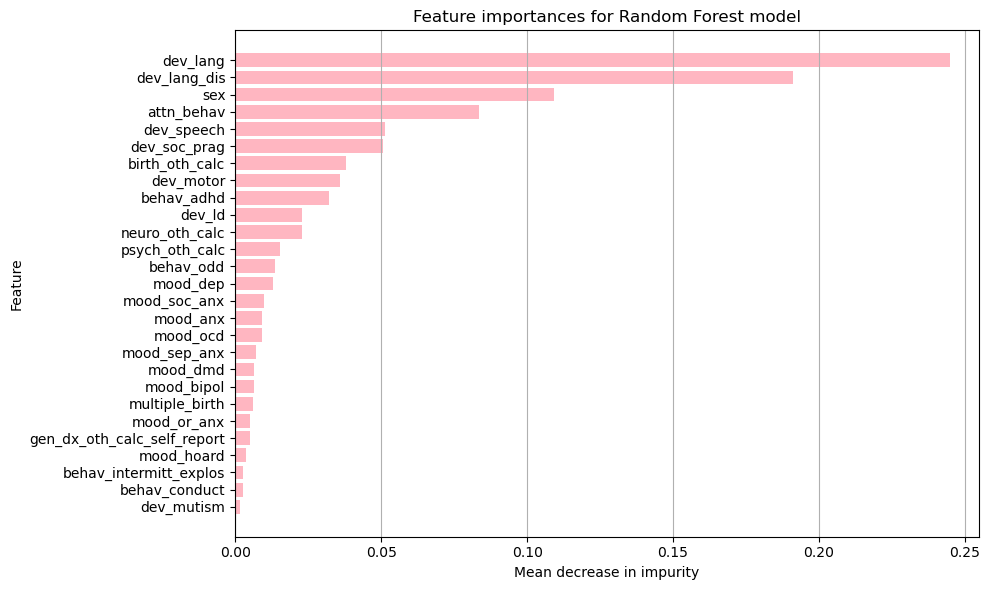

In [209]:
variable_importance_plot(rf_importances, rf_indices)

In [177]:
# Perform Cross_validation to see how robust our model is 
import time

def cross_val_metrics(fit, X_train, y_train, estimator, print_results = True):
    start = time.time()
    """
    Returns Mean Accurancy with standard_dev of model over Kfolds Validation
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
                from cross validation score's standard deviation)
    """
    my_estimators = {
    'rf': 'estimators_',
    'nn': 'out_activation_',
    'knn': '_fit_method'
    }
    try:
        # Checks whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Checks whether the model has been trained
        if not vars(fit)[my_estimators[estimator]]:
            return print("Model does not appear to be trained.")

    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
              \nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    # create KFolds validation
    n = KFold(n_splits=10)

    # record score for each split
    scores = cross_val_score(fit, 
                         X_train, 
                         y_train, 
                         cv = n)
    end = time.time() 
    # print how much time the Kfolds took
    print("Time elapsed to do Cross Validation: {0:.2f} seconds.".format(end-start))
    if print_results:
        for i in range(0, len(scores)):
            # print out the scores for each validation split
            print("Cross validation run {0}: {1: 0.3f}".format(i, scores[i]))

        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})".format(scores.mean(), scores.std() / 2))     
    else:
        return scores.mean(), scores.std() / 2

In [178]:
# call cross_val_metrics to see how our model did
cross_val_metrics(rf_classifier, 
                  X_train, 
                  y_train, 
                  'rf',
                  print_results = True)

Time elapsed to do Cross Validation: 27.23 seconds.
Cross validation run 0:  0.856
Cross validation run 1:  0.854
Cross validation run 2:  0.856
Cross validation run 3:  0.854
Cross validation run 4:  0.857
Cross validation run 5:  0.864
Cross validation run 6:  0.863
Cross validation run 7:  0.865
Cross validation run 8:  0.857
Cross validation run 9:  0.853
Accuracy:  0.858 (+/-  0.002)


In [179]:
# make a prediction on test set now that the model has been tuned and validated
rf_predictions = rf_classifier.predict(X_test)

In [180]:

def create_conf_mat(y_test, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(y_test.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics; Compute a simple cross tabulation of two (or more) factors. 
        # By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.
        test_crosstb_comp = pd.crosstab(index = y_test,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

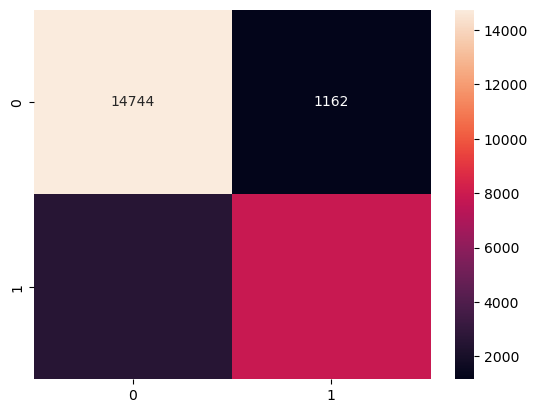

array([[14744,  1162],
       [ 2571,  7886]])

In [181]:
conf_mat = create_conf_mat(y_test, rf_predictions)

# use seaborn heatmap
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=True)
# plt.xlabel('Predicted Values')
# plt.ylabel('Actual Values')
# plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

conf_mat


In [202]:
# use built in score function to get accurancy of this model against the test set
rf_accuracy = rf_classifier.score(X_test, y_test)

print("Here is our mean accuracy on the test set:\n {0:.4f}"\
      .format(rf_accuracy))

Here is our mean accuracy on the test set:
 0.8584


In [183]:
# Here we calculate the test error rate!
rf_test_error_rate = 1 - rf_accuracy
print("The test error rate for our model is:\n {0: .4f}"\
      .format(rf_test_error_rate))

The test error rate for our model is:
  0.1416


Set up for ROC (receiver operating characteristic) curve which calculates the false positive rates and true positive rates across different thresholds.

An ideal model will have a false positive rate of 0 and true positive rate of 1. Most the curve will be in the top left corner of the graph.

On the other hand, a ROC curve that is at 45 degrees is indicative of a model that is essentially randomly guessing. Most of the curve will be in the middle of the graph.

In [184]:
# predict_proba returns two arrays that represent the predicted_prob of negative class and positive class respectively.

# I just want to take the positive classes in this instance
predictions_prob = rf_classifier.predict_proba(X_test)[:, 1]

# use roc_curve to produce 
fpr2, tpr2, _ = roc_curve(y_test,
                          predictions_prob,
                          pos_label = 1)

auc_rf = auc(fpr2, tpr2)

print(auc_rf)

0.9116666739414037


In [185]:
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

/tmp/ipykernel_466657/2153116955.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
/tmp/ipykernel_466657/2153116955.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')


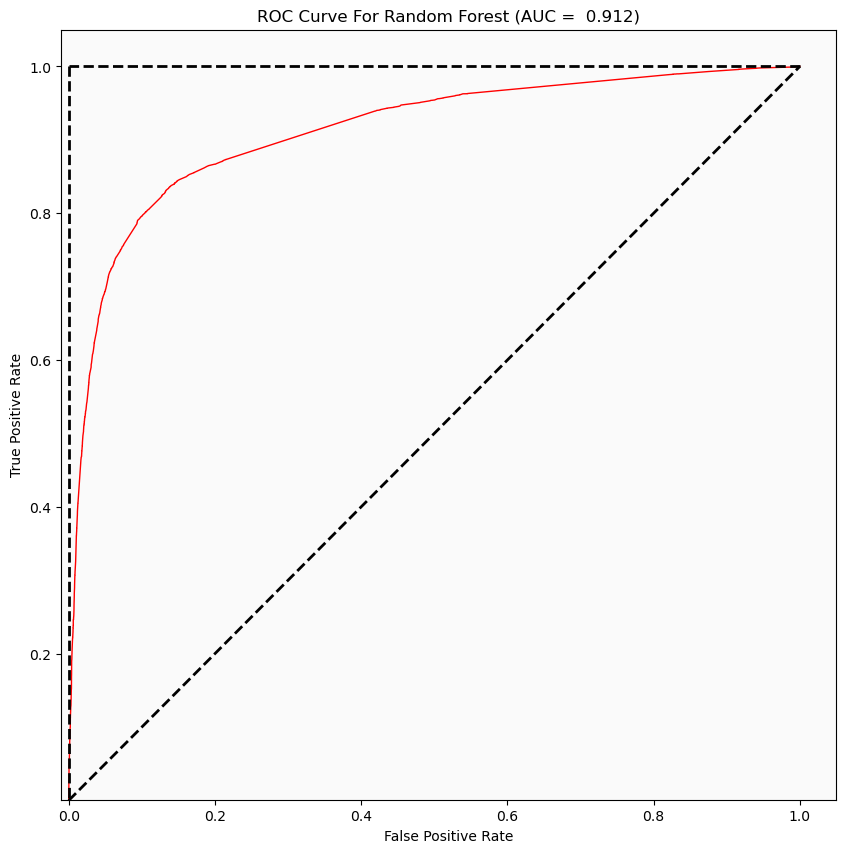

In [186]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

In [187]:
# # zoom in
# plot_roc_curve(fpr2, tpr2, auc_rf, 'rf', 
#                xlim=(-0.01, 0.2), 
#                ylim=(0.85, 1.01))

In [188]:
def print_class_report(predictions, alg_name):
    # print some title
    print('Classification Report for {0}:'.format(alg_name))
    # print class report metrics for each target 
    print(classification_report(predictions, 
            y_test, 
            target_names = ['Negative', 'Positive']))

In [189]:
class_report = print_class_report(rf_predictions, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

    Negative       0.93      0.85      0.89     17315
    Positive       0.75      0.87      0.81      9048

    accuracy                           0.86     26363
   macro avg       0.84      0.86      0.85     26363
weighted avg       0.87      0.86      0.86     26363

